In [1]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as rnd
import time
import GPflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
M = 50

# Create a dataset and initialise model

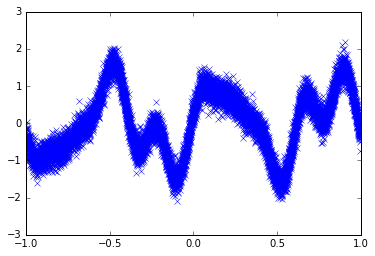

In [3]:
def func(x):
    return np.sin(x * 3*3.14) + 0.3*np.cos(x * 9*3.14) + 0.5 * np.sin(x * 7*3.14)
X = rnd.rand(10000, 1) * 2 - 1
Y = func(X) + rnd.randn(10000, 1) * 0.2
plt.plot(X, Y, 'x')
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 100)[:, None]
Yt = func(Xt)

In [4]:
def init():
    kern = GPflow.kernels.RBF(D, 1)
    Z = X[:M, :].copy()
    m = GPflow.svgp.SVGP(X, Y, kern, GPflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))
    return m
m = init()

In [5]:
m._compile()
ground_truth = m._objective(m.get_free_state())[0]
print(m.X.minibatch_size)
print(ground_truth)
print("Are the two bound calcs close enough? %s" % ("Yes" if np.allclose(m._objective(m.get_free_state())[0], ground_truth) else "No"))

compiling tensorflow function...
done
10000
17659.4731798
Are the two bound calcs close enough? Yes


# Stochastically calculate bound and show noise
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [6]:
m.X.minibatch_size = 100
m.Y.minibatch_size = 100
evals = [m._objective(m.get_free_state())[0] for _ in range(100)]

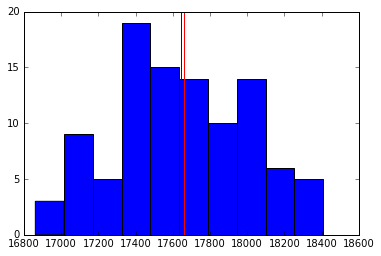

In [7]:
plt.hist(evals)
plt.axvline(np.mean(evals), color='b')
plt.axvline(ground_truth, color='r')

# Show that minibatches speed up computation
The use of using minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is cheaper. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [8]:
mbps = np.logspace(-2, 0, 10)
times = []
for mbp in mbps:
    m.X.minibatch_size = m.Y.minibatch_size = int(len(X) * mbp)
    m._compile()
    start_time = time.time()
    objs = [m._objective(m.get_free_state())[0] for _ in range(20)]
#    plt.hist(objs, bins = 100)
#    plt.axvline(ground_truth, color='r')
    times.append(time.time() - start_time)

compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done
compiling tensorflow function...
done


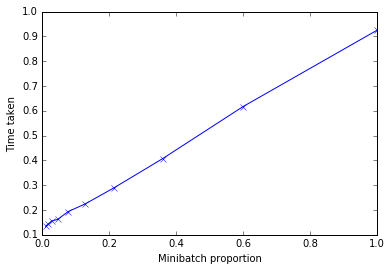

In [9]:
plt.plot(mbps, times, 'x-')
plt.xlabel("Minibatch proportion")
plt.ylabel("Time taken")

# Show actual stochastic optimization

In [10]:
m.X.minibatch_size = 100
m.Y.minibatch_size = 100

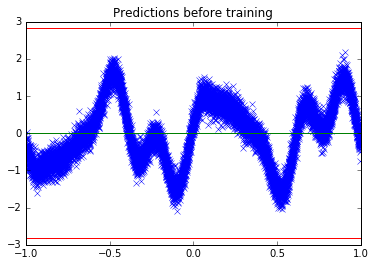

In [11]:
pX = np.linspace(-1, 1, 100)[:, None]
pY, pYv = m.predict_y(pX)
plt.plot(X, Y, 'x')
plt.plot(pX, pY)
plt.plot(pX, pY+2*pYv**0.5, 'r')
plt.plot(pX, pY-2*pYv**0.5, 'r')
plt.title("Predictions before training")

In [12]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1

In [13]:
m.optimize(method=tf.train.AdamOptimizer(learning_rate=0.0001), max_iters=np.inf, callback=logger)

compiling tensorflow function...
done
Caught KeyboardInterrupt, setting model                  with most recent state.


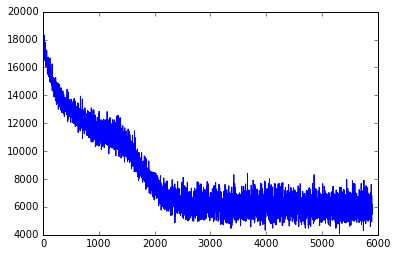

In [14]:
plt.plot(logf)

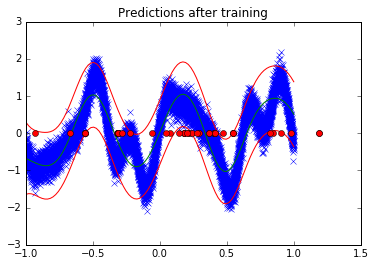

In [15]:
pY, pYv = m.predict_y(pX)
plt.plot(X, Y, 'x')
plt.plot(pX, pY)
plt.plot(pX, pY+2*pYv**0.5, 'r')
plt.plot(pX, pY-2*pYv**0.5, 'r')
plt.plot(m.Z.value, np.zeros(m.Z.value.shape), 'ro')
plt.title("Predictions after training")

N.B.: This is only an example. I didn't run the SVI code for long enough to get the inducing points to optimise well. This is hard for the stochastic optimiser to get right. On this dataset I've noticed that progress comes in waves. So you see what looks like convergence for a long time and then suddenly it'll get way better. The same frustrations as assessing Markov chain convergence I guess... But at least this shows that the cod